In [765]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from deepsetstats.dataset.court_detection.utils import Utils
import os
from os.path import join as j
os.chdir("/usr/src/app")

In [766]:
from deepsetstats.paths import (
    PATH_ANNOTATIONS_REFERENCE_PARQUET,
    PATH_IMAGES_REFCOURT
)

In [803]:
class CourtReference:
    """
    Court reference model
    """
    def __init__(self, margin_x=None, margin_y=None):
        self.white_color = (255, 255, 255)

        # Guided dims (1cm = 1 pixel)
        l04x = 1097 # court full width
        l011y = 2377 # court full height
        l01x = 137 # aisle x width
        l13x = 823 # singles court width
        l15y = 549 # y semi-bottom length
        l5nety = 640 # y service line length
        l0nety =  l5nety + l15y

        # Extra space
        if margin_x is False:
            lextrax = 0
        else:
            lextrax = 286
        if margin_y is False:
            lextray = 0
        else:
            lextray = 561

        # Global params
        self.line_width = 20
        self.court_width = l04x
        self.court_height = l011y
        self.court_singles_width = l13x
        self.margin_x = lextrax
        self.margin_y = lextray
        self.court_full_width = self.court_width + 2 * self.margin_x
        self.court_full_height = self.court_height + 2 * self.margin_y

        # Annotations
        self.font = cv2.FONT_HERSHEY_SIMPLEX

        # First reference corner point
        ref_first_point = (self.margin_x, self.margin_y)

        # Bottome Line
        self.p0 = self.add(ref_first_point, l011y, dim="y")
        self.p1 = self.add(self.p0, l01x, dim="x")
        self.p4 = self.add(self.p0, l04x, dim="x")
        self.p3 = self.add(self.p4, -l01x, dim="x")
        self.p2 = self.mid_point(self.p1, self.p3)

        # Bottom serving line
        self.p5 = self.add(self.p1, -l15y, dim="y")
        self.p7 = self.add(self.p3, -l15y, dim="y")
        self.p6 = self.mid_point(self.p5, self.p7)

        # Net
        self.net1 = self.add(self.p0, -l0nety, dim="y")
        self.net2 = self.add(self.net1, l04x, dim="x")

        # Top Line
        self.p11 = ref_first_point
        self.p12 = self.add(self.p1, -l011y, dim="y")
        self.p13 = self.add(self.p2, -l011y, dim="y")
        self.p14 = self.add(self.p3, -l011y, dim="y")
        self.p15 = self.add(self.p4, -l011y, dim="y")

        # Top Serving line
        self.p8 = self.add(self.p12, l15y, dim="y")
        self.p9 = self.add(self.p13, l15y, dim="y")
        self.p10 = self.add(self.p14, l15y, dim="y")
        
        # Plotting lines
        self.baseline_top = (self.p11, self.p15)
        self.baseline_bottom = (self.p0, self.p4)
        self.net = (self.net1, self.net2)
        self.left_court_line = (self.p0, self.p11)
        self.right_court_line = (self.p4, self.p15)
        self.left_inner_line = (self.p1, self.p12)
        self.right_inner_line = (self.p3, self.p14)
        self.middle_line = (self.p6, self.p9)
        self.top_inner_line = (self.p8, self.p10)
        self.bottom_inner_line = (self.p5, self.p7)

        # Reference points in the same order as the annotations
        self.ref_points = [
            # Bottom line from left to right
            self.p0,
            self.p1,
            self.p2,
            self.p3,
            self.p4,
            # Bottom inner-line from left to right
            self.p5,
            self.p6,
            self.p7,
            # Top inner-kine from left to right
            self.p8,
            self.p9,
            self.p10,
            # Top line from left to right
            self.p11,
            self.p12,
            self.p13,
            self.p14,
            self.p15
        ]
        
        self.key_points = [*self.baseline_top, *self.baseline_bottom, 
                          *self.left_inner_line, *self.right_inner_line,
                          *self.top_inner_line, *self.bottom_inner_line,
                          *self.middle_line]
        
        # self.court = cv2.cvtColor(cv2.imread('court_configurations/court_reference.png'), cv2.COLOR_BGR2GRAY)

    @staticmethod
    def mid_point(point1, point2):
        x1, y1 = point1
        x2, y2 = point2
        return (x1+x2) // 2, (y1+y2) // 2

    def build_court_reference(self):
        """
        Create court reference image using the lines positions
        """
        # Define the color as white (BGR format)
        court = np.zeros((self.court_full_height, self.court_full_width), dtype=np.uint8)
        cv2.line(court, *self.baseline_top, self.white_color, self.line_width)
        cv2.line(court, *self.baseline_bottom, self.white_color, self.line_width)
        cv2.line(court, *self.net, self.white_color, self.line_width)
        cv2.line(court, *self.top_inner_line, self.white_color, self.line_width)
        cv2.line(court, *self.bottom_inner_line, self.white_color, self.line_width)
        cv2.line(court, *self.left_court_line, self.white_color, self.line_width)
        cv2.line(court, *self.right_court_line, self.white_color, self.line_width)
        cv2.line(court, *self.left_inner_line, self.white_color, self.line_width)
        cv2.line(court, *self.right_inner_line, self.white_color, self.line_width)
        cv2.line(court, *self.middle_line, self.white_color, self.line_width)
        court = cv2.dilate(court, np.ones((5, 5), dtype=np.uint8))
        # plt.imsave('court_configurations/court_reference.png', court, cmap='gray')
        self.court = court
        return court


    def get_court_mask(self, mask_type=0):
        """
        Get mask of the court
        """
        mask = np.ones_like(self.court)
        if mask_type == 1:  # Bottom half court
            # mask[:self.net[0][1] - 1000, :] = 0
            mask[:self.net[0][1], :] = 0
        elif mask_type == 2:  # Top half court
            mask[self.net[0][1]:, :] = 0
        elif mask_type == 3: # court without margins
            mask[:self.baseline_top[0][1], :] = 0
            mask[self.baseline_bottom[0][1]:, :] = 0
            mask[:, :self.left_court_line[0][0]] = 0
            mask[:, self.right_court_line[0][0]:] = 0
        return mask

    def plot_ref_points(self, points="ref", show_plot=True):
        # Draw white circles on the image at specified key points
        radius = 40
        img_ref = self.build_court_reference()
        if points == "ref":
            xy_points = self.ref_points
        else:
            xy_points = self.key_points
        for i, point in enumerate(xy_points):
            x, y = point
            cv2.circle(img_ref, point, radius, self.white_color, -1)  # -1 for filled circle
            
            # Annotate with the index
            
            index_text = str(i)
            text_size = cv2.getTextSize(index_text, self.font, 2, 1)[0]
            text_x = x - radius - 70  # Adjusted for centering
            text_y = y - radius - 70  # Above the circle
            cv2.putText(img_ref, index_text, (text_x, text_y), self.font, 4, (255, 255, 255), 15, cv2.LINE_AA)  # Draw text
        if show_plot:
            Utils.plot_frame(img_ref, size=(8,8))
        return img_ref

    def plot_points_in_ref_court(self, points, annots=None, labels_pos=None, color_bgr=(0, 0, 255), 
                                 font_scale=3, radius = 40, show_plot=True):
        img_ref = self.plot_ref_points(show_plot=False)
        # Replicate img_ref along a new axis to create a 3D image
        img_ref = np.repeat(img_ref[:, :, np.newaxis], 3, axis=2)
        if labels_pos is None:
            labels_pos = ["top" for _ in range(len(points))]
        for i, point in enumerate(points):
            x, y = point
            cv2.circle(img_ref, point, radius, color_bgr, -1)  # -1 for filled circle

            # Annotate with the index
            if annots is None:
                index_text = str(i)
            else:
                index_text = annots[i]
            font_width = 1
            text_size = cv2.getTextSize(index_text, self.font, font_scale, font_width)[0]
            text_x = x - radius - 70  # Adjusted for centering
            
            if labels_pos[i] == "bottom":
                text_y = y - radius + 170  # Below the circle
            elif labels_pos[i] == "top":
                text_y = y + radius - 120  # Above the circle
            cv2.putText(img_ref, index_text, (text_x, text_y), self.font, font_scale, color_bgr, 15, cv2.LINE_AA)  # Draw text
        if show_plot:
            Utils.plot_frame(img_ref, size=(8,8))
        return img_ref

    @staticmethod
    def point_diff(point1, point2):
        x1, y1 = point1
        x2, y2 = point2
        return (x2-x1, y2-y1)

    @staticmethod
    def add(point1, value, dim="x"):
        x1, y1 = point1
        if dim == "x":
            return (x1 + value, y1)
        elif dim == "y":
            return (x1, y1 + value)

In [769]:
#c = CourtReference(margin_x=False, margin_y=False)
c = CourtReference()

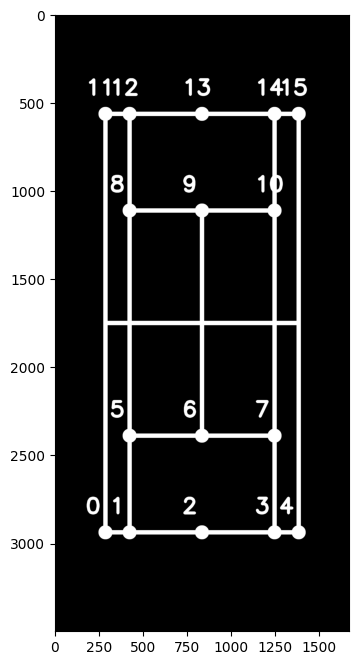

In [770]:
c.plot_ref_points(points="ref");

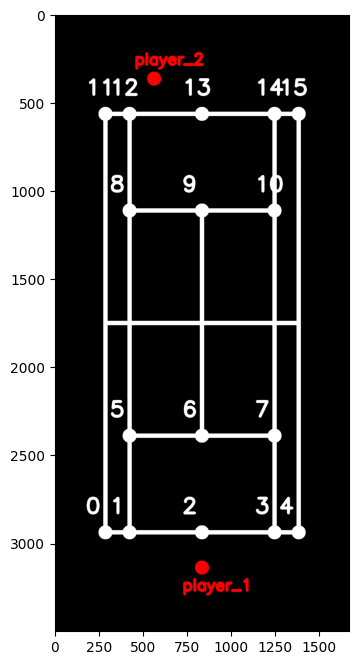

In [771]:
player1_pos = (834, 3138)
player2_pos = (562, 361)
img_ref = c.plot_points_in_ref_court(
    points=[player1_pos, player2_pos], 
    annots=["player_1", "player_2"], 
    labels_pos=["bottom", "top"]
);

# <font size=20>  Load annotations

In [772]:
df_annot = pd.read_parquet(PATH_ANNOTATIONS_REFERENCE_PARQUET, engine="pyarrow")

In [773]:
image_filename = "ref___l1000___t10___vl6Dx9KzyRig___f2052.png"
image_path = j(PATH_IMAGES_REFCOURT, image_filename)
# Load image path
img = cv2.imread(image_path)

# Load annotations
court_points = np.vstack(df_annot.loc[0]["court"])

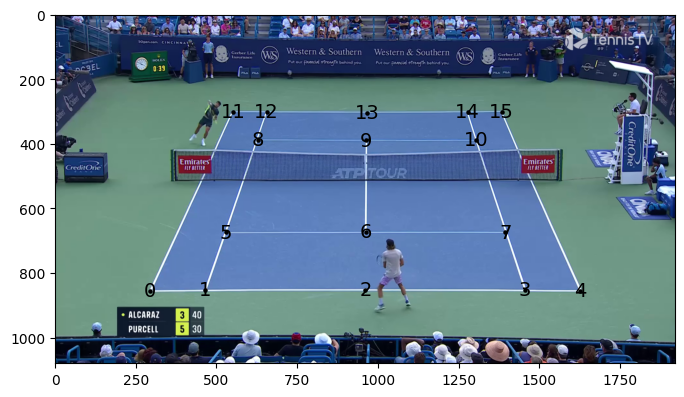

In [774]:
Utils.plot_ref_points(img, court_points);

In [829]:
img[1200:1300, 580:600]

array([], shape=(0, 20, 3), dtype=uint8)

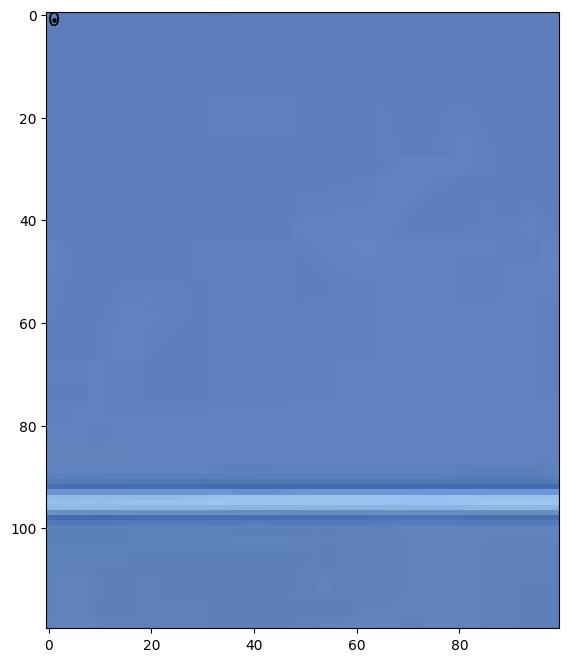

In [831]:
Utils.plot_ref_points(img[580:700, 1200:1300], [(1,1)]);

# From image to real

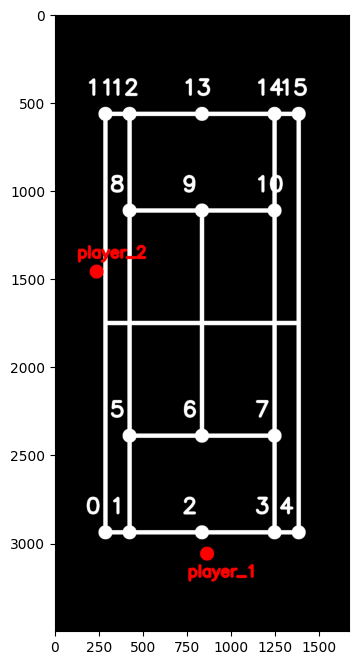

In [847]:
# ------------------------------ #
#     Real court points
# ------------------------------ #

# c = CourtReference(margin_x=False, margin_y=False)
c = CourtReference()

# reference_court_points = np.array(c.ref_points) - c.ref_points[2]
reference_court_points = np.array(c.ref_points)

# ------------------------------ #
#     Image court points
# ------------------------------ #
# Load annotations
court_points = np.vstack(df_annot.loc[0]["court"])

# ------------------------------ #
#     Homography
# ------------------------------ #

# Find the homography matrix using RANSAC method (robust to outliers)
homo_matrix, _ = cv2.findHomography(court_points, reference_court_points, cv2.RANSAC, 5.0)

# ------------------------------ #
#     From image to real
# ------------------------------ #
# Use the homography matrix to transform the point to the reference image
player1_pos = np.array([(1000, 900)], dtype=np.float32)
player2_pos = np.array([(440, 450)], dtype=np.float32)


ref_player1 = cv2.perspectiveTransform(player1_pos[None, :, :], homo_matrix).squeeze().astype(int)
ref_player2 = cv2.perspectiveTransform(player2_pos[None, :, :], homo_matrix).squeeze().astype(int)

# ------------------------------ #
#     Plot real
# ------------------------------ #
img_ref = c.plot_points_in_ref_court(
    points=[ref_player1, ref_player2], 
    annots=["player_1", "player_2"], 
    labels_pos=["bottom", "top"]
);

In [851]:
player1_pos

array([[1000.,  900.]], dtype=float32)

In [848]:
ref_player1

array([ 863, 3059])

# From real to image

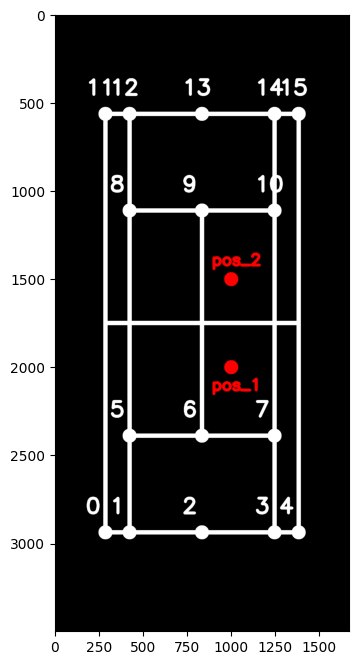

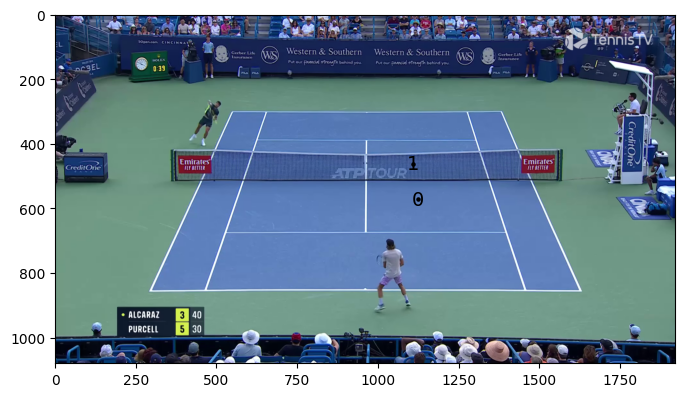

In [864]:
# ------------------------------ #
#     Real court points
# ------------------------------ #

# c = CourtReference(margin_x=False, margin_y=False)
c = CourtReference()

# reference_court_points = np.array(c.ref_points) - c.ref_points[2]
reference_court_points = np.array(c.ref_points)

# ------------------------------ #
#     Image court points
# ------------------------------ #
# Load annotations
court_points = np.vstack(df_annot.loc[0]["court"])

# ------------------------------ #
#     Homography
# ------------------------------ #

# Find the homography matrix using RANSAC method (robust to outliers)
homo_matrix, _ = cv2.findHomography(court_points, reference_court_points, cv2.RANSAC, 5.0)

# Calculate the inverse of the homography matrix
inv_homo_matrix = np.linalg.inv(homo_matrix)

# ------------------------------ #
#     From image to real
# ------------------------------ #
# Use the homography matrix to transform the point to the reference image
random_pos = np.array([(1000, 2000)], dtype=np.float32)
random_pos2 = np.array([(1000, 1500)], dtype=np.float32)

ref_pos = random_pos.squeeze().astype(int)
ref_pos2 = random_pos2.squeeze().astype(int)
img_ref = c.plot_points_in_ref_court(
    points=[ref_pos, ref_pos2], 
    annots=["pos_1", "pos_2"], 
    labels_pos=["bottom", "top"]
);


# Perspective inverse transform with homography
random_positions = np.vstack((random_pos, random_pos2))
ref_randompos = cv2.perspectiveTransform(random_positions[None, :, :], inv_homo_matrix).squeeze().astype(int)


# ------------------------------ #
#     Plot real
# ------------------------------ #
Utils.plot_ref_points(img, ref_randompos);

## Affine transformation

In [817]:
src = court_points[[0, 4, 11]].astype(np.float32)
dst = reference_court_points[[0, 4, 11]].astype(np.float32)
M = cv2.getAffineTransform(src, dst)

# src: coordinates in the source image
# dst: coordinates in the output image

In [818]:
M

array([[ 8.24023578e-01,  3.80072065e-01, -2.83414094e+02],
       [ 3.53583879e-03,  4.28096698e+00, -7.31320872e+02]])

In [819]:
# Apply the affine transformation using cv2.warpAffine()
rows, cols = img.shape[:2]
img_dst = cv2.warpAffine(img, M, (rows*2, cols*2))

(<Figure size 1400x1100 with 1 Axes>, <Axes: >)

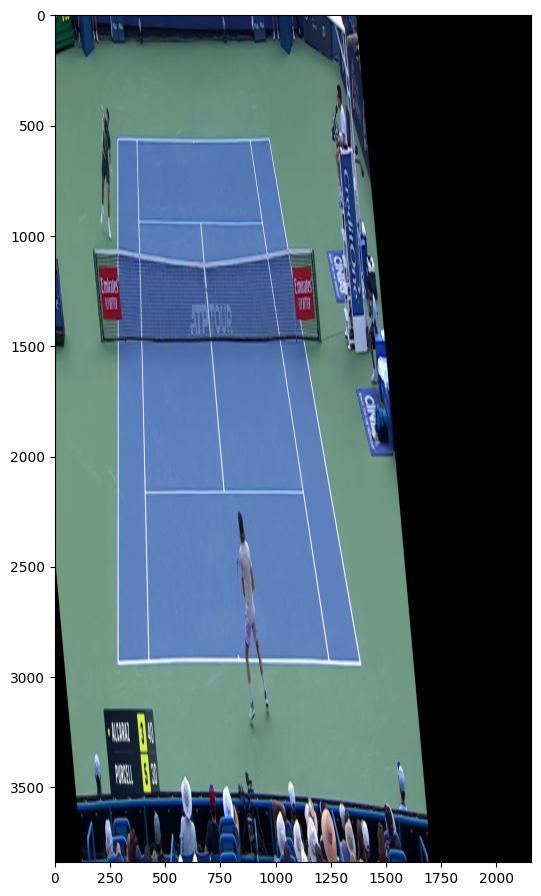

In [820]:
Utils.plot_frame(img_dst)

### Calibrate Camera

In [677]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [678]:
gray.shape

(1080, 1920)

In [679]:
img_points = []

In [680]:
# Ref points in 3D
ref_points = np.array(c.ref_points) - c.ref_points[2]
obj_points = np.zeros((ref_points.shape[0], 3))
obj_points[:,:2] = ref_points
obj_points = [obj_points.astype(np.float32) for _ in range(2)]

# Image points
img_points = [court_points[:, np.newaxis, :].astype(np.float32) for _ in range(2)]

# Perform camera calibration
ret, K, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

In [681]:
tvecs

(array([[ -19.4093481 ],
        [1330.84718023],
        [2838.91139908]]),
 array([[ -19.4093481 ],
        [1330.84718023],
        [2838.91139908]]))

In [682]:
# Convert to degrees
rvec_degrees = rvecs[0] * (180.0 / np.pi)

In [683]:
rvec_degrees

array([[-4.30133834e+01],
       [-1.13934466e-01],
       [-2.52375232e-03]])

In [684]:
def rtvec_to_matrix(rvec=(0,0,0), tvec=(0,0,0)):
    "Convert rotation vector and translation vector to 4x4 matrix"
    rvec = np.asarray(rvec)
    tvec = np.asarray(tvec)

    T = np.eye(4)
    (R, jac) = cv.Rodrigues(rvec)
    T[:3, :3] = R
    T[:3, 3] = tvec.squeeze()
    return T

In [685]:
M = rtvec_to_matrix(rvecs[0], tvecs[0])

In [686]:
M

array([[ 9.99998113e-01,  7.52041274e-04, -1.79116643e-03,
        -1.94093481e+01],
       [ 6.71990615e-04,  7.31194466e-01,  6.82168749e-01,
         1.33084718e+03],
       [ 1.82271004e-03, -6.82168665e-01,  7.31192581e-01,
         2.83891140e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

#### Inference from 3D object to 2D image point

In [687]:
# Project the 3D object points to 2D image points
pred_image_points, _ = cv2.projectPoints(obj_points[0], rvecs[0], tvecs[0], K, dist_coeffs)
pred_image_points = pred_image_points.squeeze()

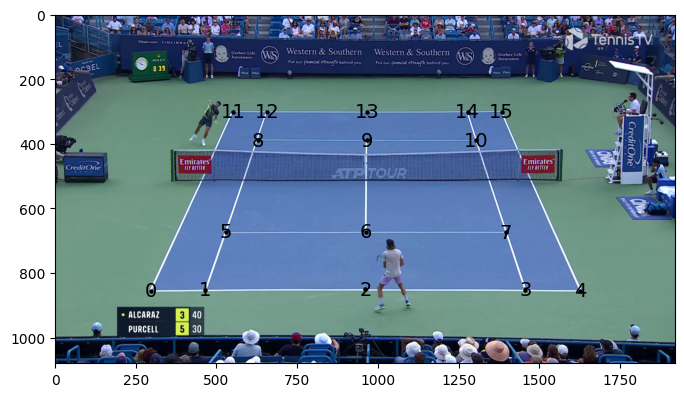

In [688]:
Utils.plot_ref_points(img, pred_image_points);

#### Play with rvec

In [689]:
import copy

In [691]:
rvecs[0]

array([[-7.50725163e-01],
       [-1.98853156e-03],
       [-4.40477875e-05]])

In [692]:
tvecs

(array([[ -19.4093481 ],
        [1330.84718023],
        [2838.91139908]]),
 array([[ -19.4093481 ],
        [1330.84718023],
        [2838.91139908]]))

In [757]:
rvec = copy.copy(rvecs[0])
# rvec[1] = -0.786
# rvec[0] = 0
# rvec[2] = 0

tvec = copy.copy(tvecs[0])
#tvec[0] = 88
#tvec[1] = 9000
# tvec[2] = tvec[2] + 500

In [758]:
rvec

array([[-7.50725163e-01],
       [-1.98853156e-03],
       [-4.40477875e-05]])

In [759]:
# Project the 3D object points to 2D image points
pred_image_points, _ = cv2.projectPoints(obj_points[0], rvec, tvec, K, dist_coeffs)
pred_image_points = pred_image_points.squeeze()

In [760]:
pred_image_points

array([[ 296.21518,  856.4976 ],
       [ 465.5495 ,  853.9241 ],
       [ 961.1778 ,  851.6182 ],
       [1457.7699 ,  853.9234 ],
       [1626.5535 ,  856.2852 ],
       [ 530.10455,  673.9367 ],
       [ 962.62885,  673.9403 ],
       [1396.5403 ,  674.26495],
       [ 628.40326,  389.3604 ],
       [ 965.8738 ,  389.62076],
       [1304.0637 ,  389.52686],
       [ 551.5658 ,  300.65756],
       [ 656.09814,  300.99487],
       [ 966.94464,  301.51083],
       [1278.5116 ,  301.16193],
       [1383.0571 ,  300.87402]], dtype=float32)

In [763]:
# Create a perspective transformation matrix (homography matrix) using the camera parameters
homography_matrix = np.zeros((3, 3), dtype=np.float32)
homography_matrix[:, :2] = np.dot(K, np.hstack((rvec, tvec)))
homography_matrix[2, 2] = 1.0

# Apply the perspective transformation to the image
width, height = img.shape[1], img.shape[0]
transformed_image = cv2.warpPerspective(img, homography_matrix, (width, height))

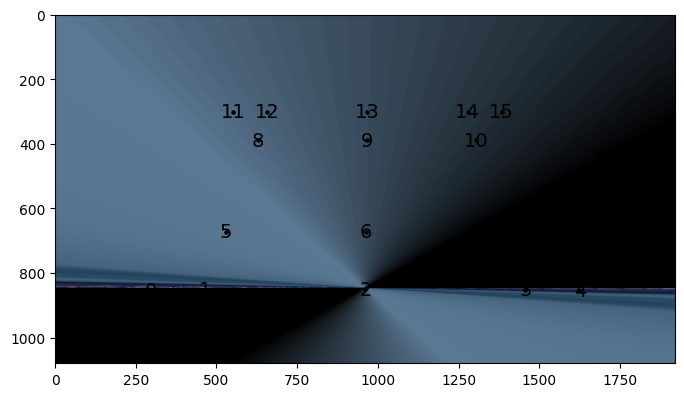

In [764]:
Utils.plot_ref_points(transformed_image, pred_image_points);

In [547]:
tvec

array([[   88.07030431],
       [ 9192.28934664],
       [14601.84458501]])

In [548]:
rvec

array([[-0.5734811 ],
       [-0.98612813],
       [ 0.41188499]])

### Toy example

In [503]:
import numpy as np
import cv2 as cv
import glob
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
path = "notebooks/datasets/"
images = [os.path.join(path, "sample.jpg"), os.path.join(path, "sample2.jpg")]
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

In [478]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [485]:
imgpoints[0].shape

(42, 1, 2)

In [486]:
objpoints[0].shape

(42, 3)

In [495]:
imgpoints[0].shape

(42, 1, 2)

(<Figure size 500x500 with 1 Axes>, <Axes: >)

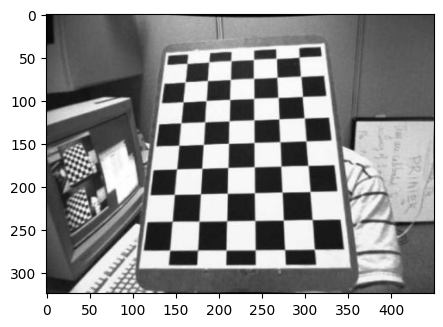

In [487]:
Utils.plot_frame(img, size=(5,5))

In [ ]:
objpoints = 

# Rotation of homography

In [267]:
# Multiply the rotation matrices and the existing homography matrix
combined_matrix = np.dot(np.dot(rotation_matrix_x, rotation_matrix_y), homo_matrix)
combined_matrix = np.dot(rotation_matrix_z, combined_matrix)

In [268]:
# Calculate the rotation matrix
# height_ref, width_ref = img.shape[:2]
# center_of_rotation = (width_ref / 2, height_ref / 2)  # Adjust if needed
# rotation_matrix = cv2.getRotationMatrix2D(center_of_rotation, rotation_angle_degrees, scale=1.0)
# 
# combined_matrix = np.dot(rotation_matrix, homo_matrix)
# 
# combined_matrix.shape

In [269]:
ref_pts.squeeze()

array([[ 286., 2938.],
       [ 423., 2938.],
       [ 834., 2938.],
       [1246., 2938.],
       [1383., 2938.],
       [ 423., 2389.],
       [ 834., 2389.],
       [1246., 2389.],
       [ 423., 1110.],
       [ 834., 1110.],
       [1246., 1110.],
       [ 286.,  561.],
       [ 423.,  561.],
       [ 834.,  561.],
       [1246.,  561.],
       [1383.,  561.]], dtype=float32)

In [270]:
# Create a new array with dimensions (16, 3)
ref_pts_3d = np.zeros((ref_pts.shape[0], 3))

In [271]:
ref_pts_3d[:, :2] = ref_pts.squeeze()
# ref_pts_3d[:, :2] =

In [272]:
# Just rotate ref in the Z axis
# ref_pts = reference_court_points.astype(np.float32)
# ref_pts = ref_pts.reshape(-1, 1, 2)
# new_court = cv2.perspectiveTransform(ref_pts_3d, rotation_matrix_z)
# new_court = new_court.squeeze().astype(int)

In [280]:
rot_pts_3d = np.dot(rotation_matrix_z, np.transpose(ref_pts_3d))

In [281]:
rot_pts_2d = rot_pts_3d[:, :2]

In [282]:
rot_pts_2d

array([[ 280.87178187,  417.87156956],
       [2938.49461085, 2938.73372084],
       [   0.        ,    0.        ]])

In [725]:
ref_pts = court_points.astype(np.float32)
ref_pts = ref_pts.reshape(-1, 1, 2)

# Create a new array with dimensions (16, 3)
ref_pts_3d = np.zeros((ref_pts.shape[0], 3))
ref_pts_3d[:, :2] = ref_pts.squeeze()

# Rotation angles in degrees for X, Y, and Z axes (adjust as needed)
rotation_angle_x_degrees = 0.005
rotation_angle_y_degrees = 0.01
rotation_angle_z_degrees = 5.0

# Convert rotation angles to radians
rotation_angle_x_radians = np.radians(rotation_angle_x_degrees)
rotation_angle_y_radians = np.radians(rotation_angle_y_degrees)
rotation_angle_z_radians = np.radians(rotation_angle_z_degrees)

# Calculate rotation matrices
rotation_matrix_x = np.array([[1, 0, 0],
                              [0, np.cos(rotation_angle_x_radians), -np.sin(rotation_angle_x_radians)],
                              [0, np.sin(rotation_angle_x_radians), np.cos(rotation_angle_x_radians)]], dtype=np.float32)

rotation_matrix_y = np.array([[np.cos(rotation_angle_y_radians), 0, np.sin(rotation_angle_y_radians)],
                              [0, 1, 0],
                              [-np.sin(rotation_angle_y_radians), 0, np.cos(rotation_angle_y_radians)]], dtype=np.float32)

rotation_matrix_z = np.array([[np.cos(rotation_angle_z_radians), -np.sin(rotation_angle_z_radians), 0],
                              [np.sin(rotation_angle_z_radians), np.cos(rotation_angle_z_radians), 0],
                              [0, 0, 1]], dtype=np.float32)

rotation_matrix_3d = np.dot(np.dot(rotation_matrix_x, rotation_matrix_y), rotation_matrix_z)


# Apply the rotation matrix to the "court_points" to get the "rotated_court_points"
rotated_pts_3d = np.dot(ref_pts_3d, rotation_matrix_3d.T)
rotated_pts_2d = rotated_pts_3d[:, :2]

In [726]:
rotation_matrix_3d

array([[ 9.9619472e-01, -8.7155744e-02,  1.7453292e-04],
       [ 8.7155759e-02,  9.9619472e-01, -8.7266460e-05],
       [-1.6626299e-04,  1.0214593e-04,  1.0000000e+00]], dtype=float32)

In [727]:
# Create a 3x3 perspective transformation matrix for the image plane
width, height = img.shape[1], img.shape[0]
center_of_rotation = (width / 2, height / 2)
scale = 1  # You can adjust the scale if needed


rotated_frame = cv2.warpPerspective(img, rotation_matrix_3d, (width, height))

In [728]:
rotated_pts = cv2.warpPerspective(ref_pts_3d, rotation_matrix_3d, (width, height))

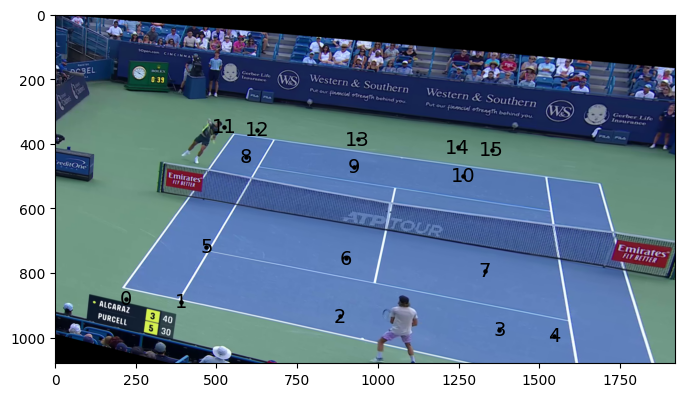

In [729]:
Utils.plot_ref_points(rotated_frame, rotated_pts_2d);

In [404]:
# Camera intrinsics
fx, fy = (1, 1)
cx, cy = (0, 0)
Z = 0.9

perspective_matrix = np.array([[fx, 0, cx],
                                [0, fy, cy],
                                [0, 0, 1./Z]], dtype=np.float32)

# Warp the image
image = img_ref
warped_image = cv2.warpPerspective(image,
                                    perspective_matrix,
                                    dsize=(image.shape[1], image.shape[0]),
                                    flags=cv2.INTER_LINEAR,
                                    borderMode=cv2.BORDER_CONSTANT,
                                    borderValue=0)

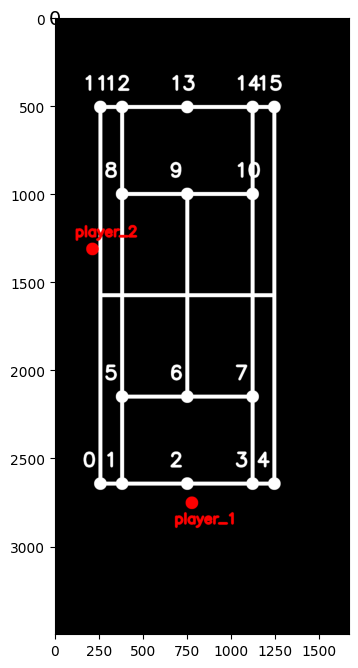

In [405]:
Utils.plot_ref_points(warped_image, [(1,1)]);

In [407]:
import cv2
import numpy as np
import math

# Rectangle dimensions
width = 20
height = 10

# Camera parameters
camera_height = 5
camera_distance = 10

# Image
image = np.zeros((height, width, 3), dtype=np.uint8)

# Find the center of the rectangle
center_x = width / 2
center_y = height / 2

# Find the top and bottom points of the rectangle
top_point = (center_x, center_y + height)
bottom_point = (center_x, center_y)

# Find the angle of the top and bottom sides of the trapezoid
angle = math.tan(height / camera_distance)

# Create the perspective matrix
perspective_matrix = cv2.getPerspectiveTransform(
    np.array([top_point, (top_point[0], top_point[1] - camera_height), bottom_point, (bottom_point[0], bottom_point[1] + camera_height)], dtype=np.float32),
    np.array([[0, 0, width], [0, height, 0], [1, 1, 1]], dtype=np.float32)
)

# Warp the image
warped_image = cv2.warpPerspective(image,
                                    perspective_matrix,
                                    dsize=(width, height),
                                    flags=cv2.INTER_LINEAR,
                                    borderMode=cv2.BORDER_CONSTANT,
                                    borderValue=0)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/imgwarp.cpp:3528: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 4 && dst.checkVector(2, CV_32F) == 4 in function 'getPerspectiveTransform'
